# Ranking of multiple systems

In this notebook we simulate situation where we have multiple system scores. We then evaluate them against different pairs of raters with different level of human agreement.

In [9]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import itertools
import numpy as np

from rsmtool.analyzer import Analyzer

from pathlib import Path

import json

from rsmtool.utils.prmse import prmse_true

from matplotlib import pyplot as plt

%matplotlib inline

In [22]:
# read in various settings
df = pd.read_csv('../data/data.csv')
config = json.load(open('settings.json'))
df_systems = pd.read_csv('../data/systems.csv')
df_raters = pd.read_csv('../data/raters.csv')
metrics_dict = json.load(open('metrics_dict.json'))
fig_dir = Path('../../../../OneDrive - Educational Testing Service/Dissemination/Papers/2020_bea_prmse/figures')

In [4]:
# get the total number of systems we have simulated
total_n_systems = sum(config['n_systems'])
total_n_systems

30

## All systems evaluated against the same pair of raters. 

Let's first look at a random pair of average raters and how are systems compare. These results are not in the paper right now.

In [41]:
human = df_raters[df_raters['category']=='average']['rater_id'].sample(n=2, random_state=32626).values
df['human'] = df[human].mean(axis=1)
h_corr = pearsonr(df[human[0]], df[human[1]])[0]
print("We selected {} and {} with HH correlation = {}".format(human[0], human[1], h_corr))

We selected h_131 and h_101 with HH correlation = 0.6462254158317621


In [6]:
system_columns = df_systems['system_id']

In [47]:
# compute evaluations for each systems against the selected pair of raters. We compute
# prmse in the same loop to keep things simple. This can take some time. 
evals = []
for s in system_columns:
    df_system_eval = pd.DataFrame(Analyzer.metrics_helper(df['human'], df[s])).transpose()
    df_system_eval.index = [s]
    df_system_eval['PRMSE'] = prmse_true(df[s], df[human])
    evals.append(df_system_eval)
df_evals = pd.concat(evals)

In [82]:
# compute degradataion, rename the metrics and merge the data frame with the system metadata
df_evals = df_evals.rename(columns=metrics_dict)
df_evals['degradation'] = df_evals['r'] - h_corr
df_evals_with_metadata = pd.merge(df_evals, df_systems, left_index=True, right_on='system_id')

In [83]:
# melt the data frame
df_evals_long = df_evals_with_metadata.melt(id_vars=['system_id', 'exp_r2_true'],
                                            value_vars=['QWK', 'r', 'R2', 'PRMSE', 'degradation'],
                                            var_name='metrics',
                                            value_name='value')

In [84]:
## define the function to get the system ranking
def get_rank(df_m):
    if df_m['metrics'].values[0] == 'degradation':
        asc = False
    else:
        asc = True
    df_m = df_m.sort_values(by='value', ascending=asc)
    df_m['rank'] = range(1, len(df_m)+1)
    return(df_m)

In [85]:
df_2h_with_rank = df_evals_long.groupby('metrics').apply(lambda x: get_rank(x)).reset_index(drop=True)

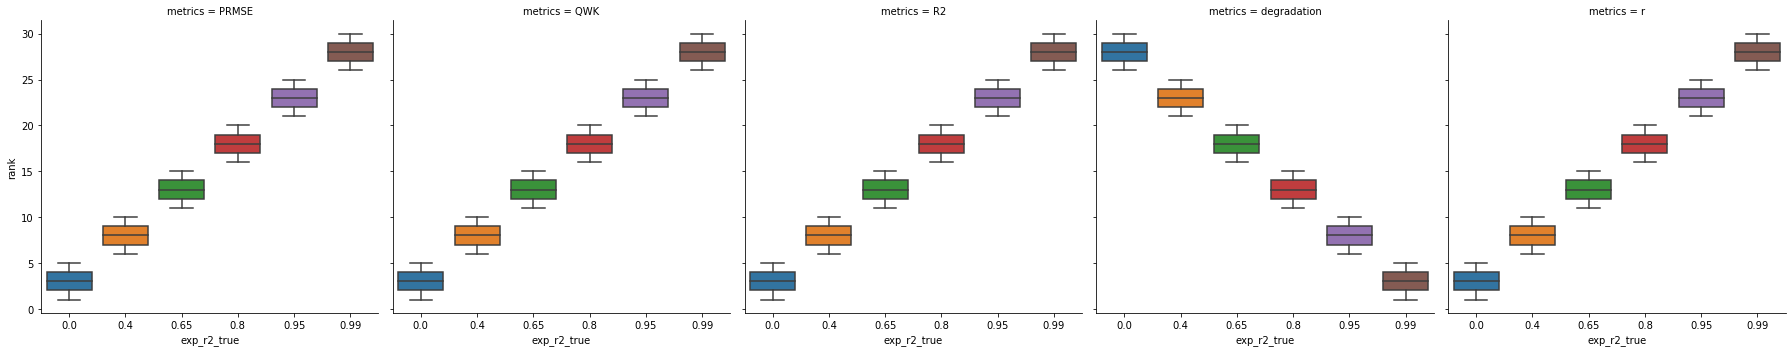

In [86]:
# plot the ranks: we expect  that all systems will be ranked correctly.
sns.catplot(x='exp_r2_true', y='rank', data=df_2h_with_rank,
           col='metrics', kind='box')

## Compare different system on different pairs

We now pick a different pair of raters to evaluate each system.

In [87]:
# generate pairs of raters for each group

def generate_rater_pairs_for_group(df_group):
    raters = df_group['rater_id']
    # get all possible rater pairs
    rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]
    return rater_pairs

In [88]:
# generate all possible pairs from each group and flatten them
selected_pairs = df_raters.groupby('category').apply(generate_rater_pairs_for_group)
all_pairs = [p for category in selected_pairs for p in category]
len(all_pairs)

4900

In [89]:
# randomly sample a pair for each system
N_pairs = total_n_systems
np.random.seed(14436323)
final_selected_pairs = np.random.choice(all_pairs, N_pairs, replace=False)
len(final_selected_pairs)

30

In [107]:
out = []
for i in range(total_n_systems):
    if i+1 % 10 == 0:
        print('{}/{}'.format(i, total_n_systems))
    humans = final_selected_pairs[i].split('+')
    system = system_columns[i]
    mean = df[humans].mean(axis=1)
    df_out = pd.DataFrame(Analyzer.metrics_helper(mean, df[system])).transpose()
    df_out['PRMSE'] = prmse_true(df[system], df[humans])
    df_out['humans'] = final_selected_pairs[i]
    df_out['h1'] = humans[0]       
    df_out['hh_corr'] = pearsonr(df[humans[0]], df[humans[1]])[0]
    df_out['system'] = [system]
    out.append(df_out)
df_nh_evals = pd.concat(out)

In [108]:
# Add the information about the category.
# We can use h1 sincethe pairs are always drawn from the same groups of raters
df_nh_with_category = pd.merge(df_nh_evals, df_raters, left_on='h1', right_on='rater_id' )
# Add information about the system
df_nh = pd.merge(df_nh_with_category, df_systems, left_on='system', right_on='system_id')

In [109]:
# Get the table with distribution between system performance and rater agreement

print(pd.crosstab(df_nh['exp_r2_true'], df_nh['category'])[config['rater_categories']].to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
category &  low &  moderate &  average &  high \\
exp\_r2\_true &      &           &          &       \\
\midrule
0.00        &    1 &         0 &        1 &     3 \\
0.40        &    2 &         1 &        2 &     0 \\
0.65        &    2 &         2 &        0 &     1 \\
0.80        &    2 &         2 &        0 &     1 \\
0.95        &    1 &         1 &        2 &     1 \\
0.99        &    2 &         2 &        1 &     0 \\
\bottomrule
\end{tabular}



In [111]:
# now compute degradation, rename the metrics and melt the data frame
df_nh = df_nh.rename(columns=metrics_dict)
df_nh['degradation'] = df_nh['r']  - df_nh['hh_corr']
df_nh_long = df_nh.melt(id_vars = ['humans', 'category', 'system', 'exp_r2_true'],
                                  value_vars = ['r', 'R2', 'QWK', 'degradation', 'PRMSE'],
                                  var_name = 'metrics', value_name = 'value')

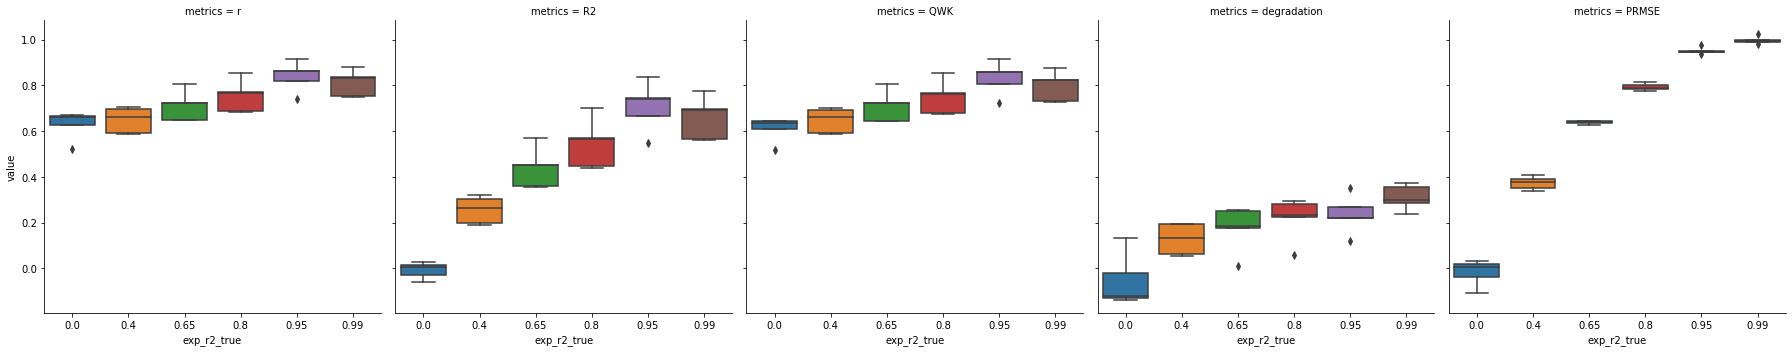

In [112]:
# Plot the raw values by known system prformance
ax = sns.catplot(col='metrics', y='value', x='exp_r2_true', data=df_nh_long,
                kind='box')

In [113]:
# now add ranks

df_nh_with_rank = df_nh_long.groupby('metrics').apply(lambda x: get_rank(x)).reset_index(drop=True)

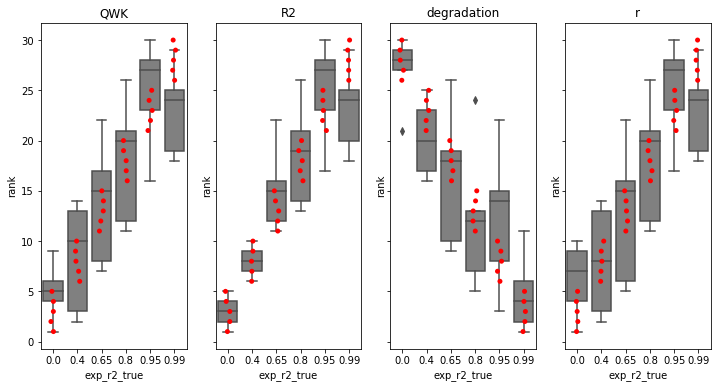

In [115]:
# plot the ranks. We overlay the ranks we computed for the same pair in the first part of this notebook.

plot_metrics = ['r', 'QWK', 'R2', 'degradation']

fig, axes = plt.subplots(ncols=len(plot_metrics), sharex=True, sharey=True, figsize=(12, 6))

data_for_plot = df_nh_with_rank[df_nh_with_rank['metrics'].isin(plot_metrics)]

for ax, (n, grp) in zip(axes, data_for_plot.groupby("metrics")):
    sns.boxplot(x="exp_r2_true", y="rank", data=grp, ax=ax, color='grey')
    ref_data = df_2h_with_rank[df_2h_with_rank['metrics']==n]
    sns.stripplot(x="exp_r2_true", y="rank", data=ref_data, color='red', ax=ax)
    ax.set_title(n)
#axes[-1].get_legend().remove()
plt.show()
fig.savefig(fig_dir / 'system_comparison.png')

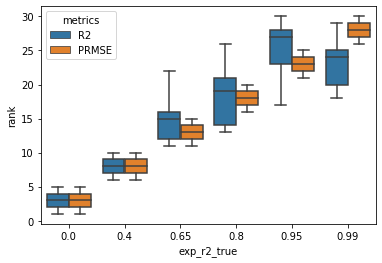

In [117]:
# Now let's plot PRMSE and R2 only 

data_for_plot = df_nh_with_rank[df_nh_with_rank['metrics'].isin(['PRMSE', 'R2'])]

ax = sns.boxplot(x="exp_r2_true", y="rank", data=data_for_plot, hue='metrics',
                 hue_order=['R2', 'PRMSE'])
#axes[-1].get_legend().remove()
#plt.show()
plt.savefig(fig_dir / 'prmse_comparison.png')